In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [1]:
class Actuator:
    def __init__(self, initial_torque):
        self.torque = initial_torque

    def apply_torque(self, torque):
        self.torque = torque
        # Implement the logic to apply torque to the joint


class Sensor:
    def __init__(self):
        self.position = 0
        self.velocity = 0
        self.acceleration = 0

    def update_readings(self, position, velocity, acceleration):
        self.position = position
        self.velocity = velocity
        self.acceleration = acceleration
        # Update sensor readings based on the joint's movement


class Joint:
    def __init__(self, actuator, sensor, initial_degree):
        self.actuator = actuator
        self.sensor = sensor
        self.degree = initial_degree

    def move(self, torque):
        # Use the actuator to apply torque
        self.actuator.apply_torque(torque)
        # Logic for moving the joint and updating the sensor readings
        # For example:
        self.sensor.update_readings(self.degree, 0, 0)  # Placeholder values


class RoboticArm:
    def __init__(self):
        self.joint1 = Joint(Actuator(initial_torque=0), Sensor(), initial_degree=0)
        self.joint2 = Joint(Actuator(initial_torque=0), Sensor(), initial_degree=0)
        self.position_sensor = Sensor()

    def move_joints(self, torque1, torque2):
        self.joint1.move(torque1)
        self.joint2.move(torque2)
        # Logic to determine the end position based on joint movements
        # Update position sensor
        self.position_sensor.update_readings(0, 0, 0)  # Placeholder values

    def get_end_position(self):
        # Calculate the end position of the robotic arm
        # Return end position
        return (0, 0)  # Placeholder values


# Example usage:
robotic_arm = RoboticArm()
robotic_arm.move_joints(torque1=10, torque2=20)
end_position = robotic_arm.get_end_position()
print(f"The end position of the robotic arm is {end_position}")

The end position of the robotic arm is (0, 0)


In [3]:
# Define the parameters and state variables
m1, m2 = 0.8, 0.4  # masses of the links
l1, l2 = 1.0, 0.5  # lengths of the links
g = 9.81  # acceleration due to gravity
theta1, theta2 = np.radians(30), np.radians(45)  # joint angles in radians
dtheta1, dtheta2 = 0.0, 0.0  # joint angular velocities
ddtheta1, ddtheta2 = 0.0, 0.0  # joint angular accelerations

# Define the equations using numpy for trigonometric functions and linear algebra
def calculate_torques(theta1, theta2, dtheta1, dtheta2, ddtheta1, ddtheta2):
    D11 = (m1 + m2) * l1**2 + m2 * l2**2 + 2 * m2 * l1 * l2 * np.cos(theta2)
    D12 = D21 = m2 * l2**2 + m2 * l1 * l2 * np.cos(theta2)
    D22 = m2 * l2**2

    C1 = -m2 * l1 * l2 * np.sin(theta2) * dtheta2**2 - m2 * l1 * l2 * np.sin(theta2) * (dtheta1 + dtheta2)
    C2 = m2 * l1 * l2 * np.sin(theta2) * dtheta1**2

    G1 = (m1 + m2) * g * l1 * np.cos(theta1) + m2 * g * l2 * np.cos(theta1 + theta2)
    G2 = m2 * g * l2 * np.cos(theta1 + theta2)

    # Inertia matrix
    D = np.array([[D11, D12],
                  [D21, D22]])
    
    # Coriolis and centrifugal vector
    C = np.array([C1, C2])
    
    # Gravity vector
    G = np.array([G1, G2])
    
    # Angular acceleration vector
    ddtheta = np.array([ddtheta1, ddtheta2])
    
    # Calculate torques
    T = np.dot(D, ddtheta) + C + G
    return T

# Calculate torques for the given state
torques = calculate_torques(theta1, theta2, dtheta1, dtheta2, ddtheta1, ddtheta2)
torques

array([10.70265402,  0.50780297])

In [ ]:
def control(theta1, d_theta1, DD_theta1, theta2, d_theta2, DD_theta2, lambda1, de1, lambda2, de2):
    # Constants
    l1 = 1; m1 = 0.8; l2 = 0.5; m2 = 0.4; g = 9.8
    
    # Inertia matrix components
    D11 = (m1 + m2) * l1**2 + m2 * l2**2 + 2 * m2 * l1 * l2 * np.cos(theta2)
    D12 = m2 * l2**2 + m2 * l1 * l2 * np.cos(theta2)
    D21 = D12  # since D12 == D21 in a symmetric matrix
    D22 = m2 * l2**2
    
    # Coriolis and centrifugal force vector components
    Z = m2 * l1 * l2 * np.sin(theta2)
    
    # Gravity vector components
    G1 = (m1 + m2) * g * l1 * np.cos(theta1) + m2 * g * l2 * np.cos(theta1 + theta2)
    G2 = m2 * g * l2 * np.cos(theta1 + theta2)
    
    # Torque inputs
    T1 = D11 * DD_theta1 + D12 * DD_theta2 - Z * d_theta2**2 + G1
    T2 = D21 * DD_theta1 + D22 * DD_theta2 + Z * d_theta1**2 + G2
    
    # Control outputs
    y1 = -T1 + DD_theta1 - lambda1 * de1
    y2 = -T2 + DD_theta2 - lambda2 * de2
    
    return y1, y2

# Example usage:
theta1, d_theta1, DD_theta1 = np.radians(30), 0, 0
theta2, d_theta2, DD_theta2 = np.radians(45), 0, 0
lambda1, de1 = 5, 0.1
lambda2, de2 = 5, 0.1

y1, y2 = control(theta1, d_theta1, DD_theta1, theta2, d_theta2, DD_theta2, lambda1, de1, lambda2, de2)
print(f"Control Output 1: {y1}, Control Output 2: {y2}")

In [ ]:
def smc_signal(e, d_e, K, lambda_, delay):
    s = lambda_ * e + d_e
    if abs(s) > delay:
        sat_s = np.sign(s)
    else:
        sat_s = s / delay
    SMC_Signal = -K * sat_s
    return SMC_Signal

# Example usage:
e = 0.1  # error
d_e = 0.01  # derivative of error
K = 5  # gain
lambda_ = 2  # lambda
delay = 0.01  # delay

signal = smc_signal(e, d_e, K, lambda_, delay)
print(f"SMC Signal: {signal}")

In [ ]:
t = np.linspace(0, 10, 500)  # 10 seconds, 500 points

# Sinusoidal input for desired x value
amplitude = 1  # Amplitude of the sine wave
frequency = 1  # Frequency (number of cycles per second)
desired_x = amplitude * np.sin(2 * np.pi * frequency * t)

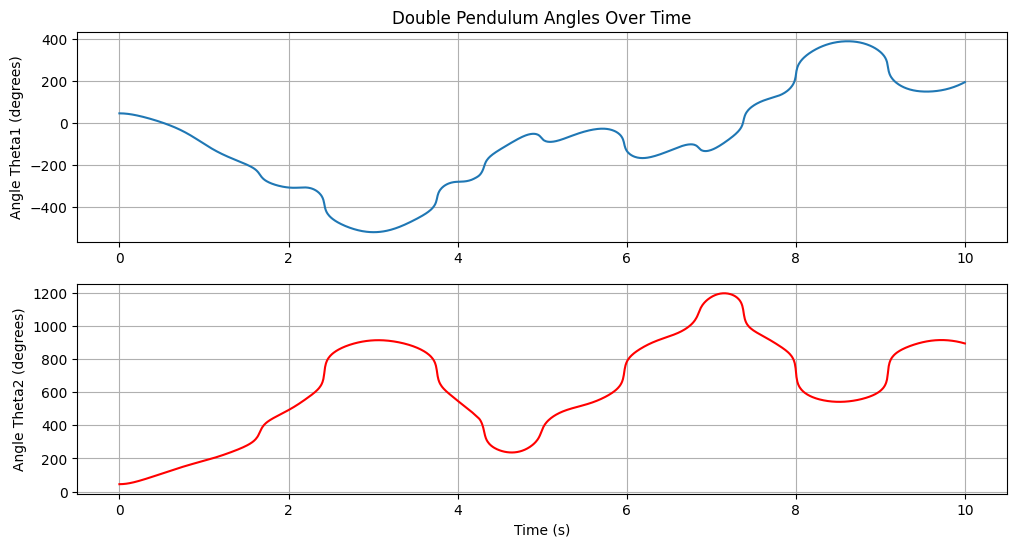

In [5]:
def calculate_accelerations(theta1, theta2, dtheta1, dtheta2, m1, m2, l1, l2, g):
    # Inertia matrix components
    D11 = (m1 + m2) * l1**2 + m2 * l2**2 + 2 * m2 * l1 * l2 * np.cos(theta2)
    D12 = D21 = m2 * l2**2 + m2 * l1 * l2 * np.cos(theta2)
    D22 = m2 * l2**2

    # Inertia matrix
    D = np.array([[D11, D12], [D21, D22]])
    D_inv = np.linalg.inv(D)

    # Coriolis and centrifugal forces
    C1 = -m2 * l1 * l2 * np.sin(theta2) * dtheta2**2 - m2 * l1 * l2 * np.sin(theta2) * (dtheta1 + dtheta2)
    C2 = m2 * l1 * l2 * np.sin(theta2) * dtheta1**2

    # Gravitational forces
    G1 = (m1 + m2) * g * l1 * np.cos(theta1) + m2 * g * l2 * np.cos(theta1 + theta2)
    G2 = m2 * g * l2 * np.cos(theta1 + theta2)

    # Combine Coriolis, centrifugal, and gravitational forces
    C_plus_G = np.array([C1, C2]) + np.array([G1, G2])

    # Calculate angular accelerations
    ddtheta = np.dot(D_inv, -C_plus_G)
    return ddtheta

# Simulation parameters
m1, m2 = 1.0, 1.0  # masses of the links
l1, l2 = 1.0, 1.0  # lengths of the links
g = 9.81            # gravitational acceleration

# Initial conditions
theta1_0, theta2_0 = np.radians(45), np.radians(45)  # initial angles
dtheta1_0, dtheta2_0 = 0.0, 0.0                     # initial angular velocities
state0 = [theta1_0, theta2_0, dtheta1_0, dtheta2_0]

# Equations of motion
def eom(t, y):
    theta1, theta2, dtheta1, dtheta2 = y
    ddtheta1, ddtheta2 = calculate_accelerations(theta1, theta2, dtheta1, dtheta2, m1, m2, l1, l2, g)
    return [dtheta1, dtheta2, ddtheta1, ddtheta2]

# Time array for the simulation
t_span = np.linspace(0, 10, 1000)  # 10 seconds, 1000 steps

# Solve the equations of motion
solution = solve_ivp(eom, (0, 10), state0, t_eval=t_span)

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(solution.t, np.degrees(solution.y[0]), label="Theta1")
plt.title('Double Pendulum Angles Over Time')
plt.ylabel('Angle Theta1 (degrees)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(solution.t, np.degrees(solution.y[1]), label="Theta2", color='r')
plt.xlabel('Time (s)')
plt.ylabel('Angle Theta2 (degrees)')
plt.grid(True)

plt.show()

In [6]:
from matplotlib.animation import FuncAnimation

# Function to calculate the position of each pendulum
def calculate_positions(theta1, theta2, l1, l2):
    x1 = l1 * np.sin(theta1)
    y1 = -l1 * np.cos(theta1)
    x2 = x1 + l2 * np.sin(theta1 + theta2)
    y2 = y1 - l2 * np.cos(theta1 + theta2)
    return x1, y1, x2, y2

# Number of frames for the GIF
num_frames = 100
frame_indices = np.linspace(0, len(solution.t) - 1, num_frames, dtype=int)

# Initialize the figure for animation
fig, ax = plt.subplots()
ax.set_xlim(-2 * (l1 + l2), 2 * (l1 + l2))
ax.set_ylim(-2 * (l1 + l2), 2 * (l1 + l2))
line, = ax.plot([], [], 'o-', lw=2)
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

# Animation update function
def update(frame):
    i = frame_indices[frame]
    theta1, theta2 = solution.y[0, i], solution.y[1, i]
    x1, y1, x2, y2 = calculate_positions(theta1, theta2, l1, l2)
    line.set_data([0, x1, x2], [0, y1, y2])
    time_text.set_text(f'Time = {solution.t[i]:.2f}s')
    return line, time_text

# Create the animation
ani = FuncAnimation(fig, update, frames=num_frames, blit=True, interval=100)

# Display the animation
plt.close(fig)  # Prevents duplicate display
ani  # This line displays the animation in the notebook, but does not create a GIF file

In [8]:
ani.save('double_pendulum.gif', writer='imagemagick')

In [9]:
def calculate_accelerations_with_torques(theta1, theta2, dtheta1, dtheta2, m1, m2, l1, l2, g, t):
    # Inertia matrix components
    D11 = (m1 + m2) * l1**2 + m2 * l2**2 + 2 * m2 * l1 * l2 * np.cos(theta2)
    D12 = D21 = m2 * l2**2 + m2 * l1 * l2 * np.cos(theta2)
    D22 = m2 * l2**2

    # Inertia matrix
    D = np.array([[D11, D12], [D21, D22]])
    D_inv = np.linalg.inv(D)

    # Coriolis and centrifugal forces
    C1 = -m2 * l1 * l2 * np.sin(theta2) * dtheta2**2 - 2 * m2 * l1 * l2 * np.sin(theta2) * dtheta2
    C2 = m2 * l1 * l2 * np.sin(theta2) * dtheta1**2

    # Gravitational forces
    G1 = (m1 + m2) * g * l1 * np.cos(theta1) + m2 * g * l2 * np.cos(theta1 + theta2)
    G2 = m2 * g * l2 * np.cos(theta1 + theta2)

    # Specified torques: sin and cosine waves with small amplitudes
    torque1 = 0.1 * np.sin(t)
    torque2 = 0.1 * np.cos(t)

    # Torque vector
    T = np.array([torque1, torque2])

    # Combine Coriolis, centrifugal, gravitational forces and torques
    C_plus_G_plus_T = np.array([C1, C2]) + np.array([G1, G2]) + T

    # Calculate angular accelerations
    ddtheta = np.dot(D_inv, C_plus_G_plus_T)
    return ddtheta

# Equations of motion with torques
def eom_with_torques(t, y):
    theta1, theta2, dtheta1, dtheta2 = y
    ddtheta1, ddtheta2 = calculate_accelerations_with_torques(theta1, theta2, dtheta1, dtheta2, m1, m2, l1, l2, g, t)
    return [dtheta1, dtheta2, ddtheta1, ddtheta2]

# Solve the equations of motion with specified torques
solution_with_torques = solve_ivp(eom_with_torques, (0, 10), state0, t_eval=t_span)

# Animation with torques
fig, ax = plt.subplots()
ax.set_xlim(-2 * (l1 + l2), 2 * (l1 + l2))
ax.set_ylim(-2 * (l1 + l2), 2 * (l1 + l2))
line_with_torques, = ax.plot([], [], 'o-', lw=2, color='green')
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

# Update function for the animation with torques
def update_with_torques(frame):
    i = frame_indices[frame]
    theta1, theta2 = solution_with_torques.y[0, i], solution_with_torques.y[1, i]
    x1, y1, x2, y2 = calculate_positions(theta1, theta2, l1, l2)
    line_with_torques.set_data([0, x1, x2], [0, y1, y2])
    time_text.set_text(f'Time = {solution_with_torques.t[i]:.2f}s')
    return line_with_torques, time_text

# Create the animation with torques
ani_with_torques = FuncAnimation(fig, update_with_torques, frames=num_frames, blit=True, interval=100)

# Display the animation
plt.close(fig)  # Prevents duplicate display
ani_with_torques  # Displays the animation in the notebook, but does not create a GIF file

In [10]:
ani_with_torques.save('double_pendulum2.gif', writer='imagemagick')